In [ ]:
!pip install tensorflow_datasets

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras.models import load_model
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.utils import np_utils
from keras import Model
from numpy import zeros, ones, vstack, expand_dims
from numpy.random import randn, randint
from keras.datasets.cifar10 import load_data
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot as plt
import cv2

# Prep Data

In [ ]:
# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name="cifar10", split=tfds.Split.TRAIN, batch_size=-1 )
cifar10_test = tfds.load(name="cifar10", split=tfds.Split.TEST, batch_size=-1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train)
cifar10_test = tfds.as_numpy(cifar10_test)

# Seperate feature X and label Y
X_train, y_train = cifar10_train["image"], cifar10_train["label"]
X_test, y_test = cifar10_test["image"], cifar10_test["label"]

# Print shapes of the entire training and test set of CIFAR 10
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteBHNXJI/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteBHNXJI/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (50000,)
y_test shape: (10000,)


In [ ]:
# Get samples  of a certain label
label = 8 # Class '1' is car. You may change this label to another class label.
train_indices = np.where(y_train == label) # Get indices of the label
train_set = X_train[train_indices] # Get train samples of the label
test_indices = np.where(y_test == label) # Get indices of the label
test_set = X_test[test_indices] # Get test samples of the label

#Stack all boat images into one variable
train_set = vstack((train_set, test_set))

# Print shapes of datasets of the selected class
print("train_set shape of the selected class: " + str(train_set.shape))
print("test_set shape of the selected class: " + str(test_set.shape))

train_set shape of the selected class: (6000, 32, 32, 3)
test_set shape of the selected class: (1000, 32, 32, 3)


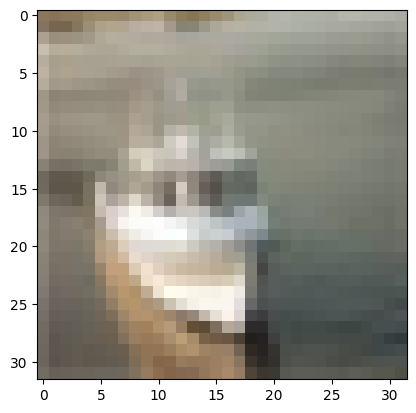

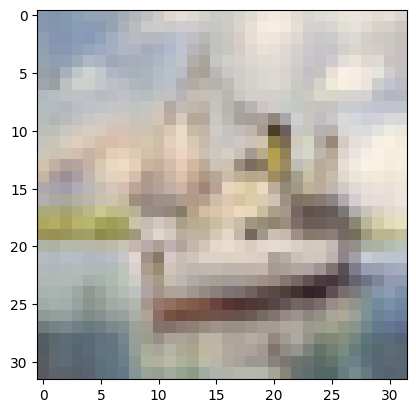

In [ ]:
imgplot = plt.imshow(train_set[5550])
plt.show()
imgplot = plt.imshow(train_set[1])
plt.show()

# Vanilla GAN Section

In [ ]:
def define_discriminator(in_shape=(32,32,3)):
		model = Sequential()

		model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape))
		model.add(LeakyReLU(alpha=0.2))

		model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
		model.add(LeakyReLU(alpha=0.2))

		model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
		model.add(LeakyReLU(alpha=0.2))

		model.add(Conv2D(512, (3,3), strides=(2,2), padding='same'))
		model.add(LeakyReLU(alpha=0.2))

		# classifier
		model.add(Flatten())
		model.add(Dropout(0.4))
		model.add(Dense(1, activation='sigmoid'))


		# compile model
		opt = Adam(lr=0.0002, beta_1=0.5)
		model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
		return model
test_dis = define_discriminator()
test_dis.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 512)         1

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def define_generator(latent_dim):
		model = Sequential()

		n_nodes = 128 * 8 * 8  #8192 nodes
		model.add(Dense(n_nodes, input_dim=latent_dim))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Reshape((8, 8, 128)))
		# upsample to 16x16
		model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
		model.add(LeakyReLU(alpha=0.2))
		# upsample to 32x32
		model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
		model.add(LeakyReLU(alpha=0.2))
		# generate
		model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
		return model
test_gen = define_generator(100)
test_gen.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [ ]:
# define the combined generator and discriminator model
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model




In [ ]:
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

In [ ]:
def load_real_samples(dataset):
	trainX = dataset
	# Convert to float and scale.
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale original images to -1 to 1 to match the output of generator.
	return X


def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	# set label to 1 which means it's real
	y = ones((n_samples, 1))
	return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples.
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake.
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, dis_name, gen_name, n_batch=64):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)

	#Initialize the list of loss values
	d_loss_values = []
	g_loss_values = []
	# manually enumerate epochs and batthes.
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):


			# Get randomly selected real samples
			X_real, y_real = generate_real_samples(dataset, half_batch)

			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

			# Train the discriminator on real and fake images
			d_loss, _ = d_model.train_on_batch(X, y)

			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

			y_gan = ones((n_batch, 1))

			g_loss = gan_model.train_on_batch(X_gan, y_gan)

      # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d_loss=%.3f, g_loss=%.3f' %	(i+1, j+1, bat_per_epo, d_loss, g_loss))
			d_loss_values.append(d_loss)
			g_loss_values.append(g_loss)
	# save the generator model
	d_model.save(dis_name)
	g_model.save(gen_name)
	return d_loss_values, g_loss_values


In [ ]:
#Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples(train_set)
# train model
d_losses, g_losses = train(generator, discriminator, gan_model, dataset, latent_dim, 101, "cifar10_discriminator.h5", "cifar10_generator.h5")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
Epoch>75, Batch 12/93, d_loss=0.456, g_loss=1.150
1/1 [==============================] - 0s 16ms/step
Epoch>75, Batch 13/93, d_loss=0.463, g_loss=1.565
1/1 [==============================] - 0s 16ms/step
Epoch>75, Batch 14/93, d_loss=0.409, g_loss=1.739
1/1 [==============================] - 0s 18ms/step
Epoch>75, Batch 15/93, d_loss=0.355, g_loss=2.083
1/1 [==============================] - 0s 16ms/step
Epoch>75, Batch 16/93, d_loss=0.491, g_loss=1.407
1/1 [==============================] - 0s 24ms/step
Epoch>75, Batch 17/93, d_loss=0.347, g_loss=1.266
1/1 [==============================] - 0s 17ms/step
Epoch>75, Batch 18/93, d_loss=0.390, g_loss=2.511
1/1 [==============================] - 0s 17ms/step
Epoch>75, Batch 19/93, d_loss=0.375, g_loss=1.459
1/1 [==============================] - 0s 16ms/step
Epoch>75, Batch 20/93, d_loss=0.380, g_loss=1.362
1/1 [==========================

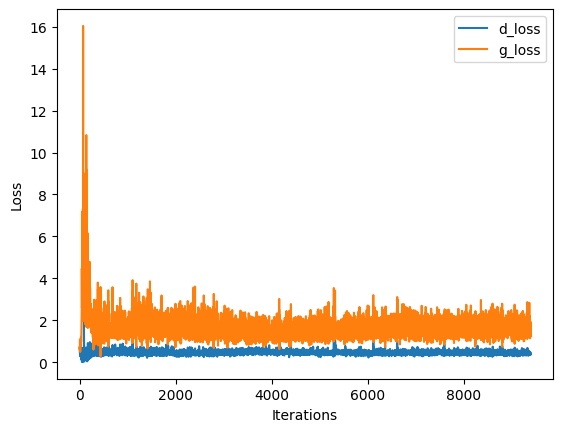

In [ ]:
#Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses), len(d_losses))
gx = np.linspace(0,len(g_losses), len(d_losses))

# Plot the training loss of G and D
plt.plot(dx, d_losses)
plt.plot(gx, g_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 106ms/step


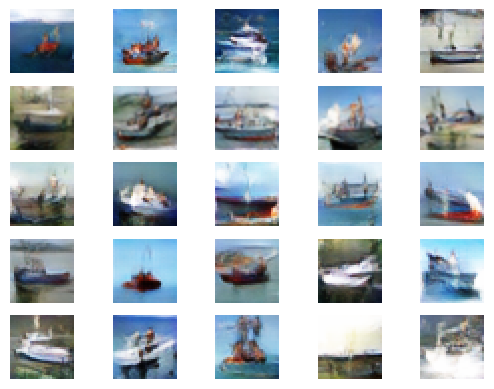

In [ ]:
# load model
model = load_model('/content/cifar10_generator.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X_fake = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X_fake = (X_fake + 1) / 2.0

import numpy as np
X_fake = (X_fake*255).astype(np.uint8)

# plot the result
show_plot(X_fake, 5)

# Basic 4 level ProGan

# Lv1 (4x4)

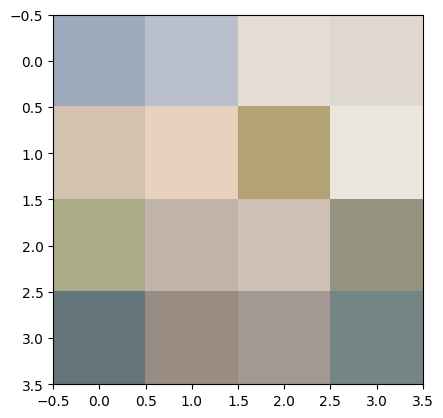

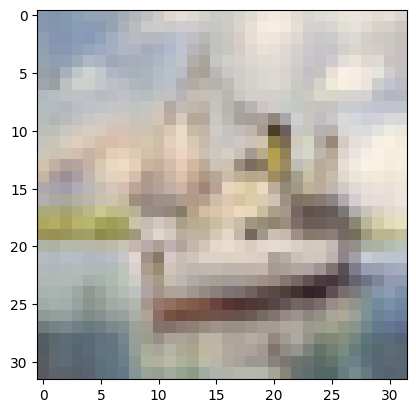

In [ ]:
#Resize train_set to get real images for 4x4 discriminator
lv1_set = np.array([cv2.resize(img, (4, 4)) for img in train_set])

imgplot = plt.imshow(lv1_set[1])
plt.show()
imgplot = plt.imshow(train_set[1])
plt.show()

In [ ]:
def define_discriminator_lv1(in_shape=(4,4,3)):
		model = Sequential()

		model.add(Conv2D(512, (2,2), padding='same', input_shape=in_shape))
		model.add(LeakyReLU(alpha=0.2))

		#Here I use 1x1 Convolution because if I use 2x2 convolution, the output feature map will only be 2x2 which is too small for the
		#discriminator to properly predict.
		model.add(Conv2D(512, (2,2), strides=(1,1), padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		# classifier
		model.add(Flatten())
		model.add(Dropout(0.4))
		model.add(Dense(1, activation='sigmoid'))

		# compile model
		opt = Adam(lr=0.0002, beta_1=0.5)
		model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
		return model
test_dis = define_discriminator_lv1()
test_dis.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 4, 4, 512)         6656      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 512)         1049088   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_1 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
def define_generator_lv1(latent_dim):
		model = Sequential()
		n_nodes = 512 * 2 * 2  #2048 nodes
		model.add(Dense(n_nodes, input_dim=latent_dim))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Reshape((2, 2, 512)))
		# upsample to 4x4
		model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		# generate
		model.add(Conv2D(3, (8,8), activation='tanh', padding='same'))

		return model
test_gen = define_generator_lv1(100)
test_gen.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 2048)              206848    
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_19 (Reshape)        (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 4, 4, 128)        1048704   
 Transpose)                                                      
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 4, 4, 128)         0         
                                                                 
 conv2d_35 (Conv2D)          (None, 4, 4, 3)           24579     
                                                     

In [ ]:
latent_dim = 100
# create the discriminator
discriminator_lv1 = define_discriminator_lv1()
# create the generator
generator_lv1 = define_generator_lv1(latent_dim)
# create the gan
gan_model_lv1 = define_gan(generator_lv1, discriminator_lv1)
# load image data
dataset = load_real_samples(lv1_set)
# train model
d_losses, g_losses = train(generator_lv1, discriminator_lv1, gan_model_lv1, dataset, latent_dim, 101, "cifar_dis_lv1.h5", "cifar_gen_lv1.h5")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 15ms/step
Epoch>75, Batch 12/93, d_loss=0.703, g_loss=0.745
1/1 [==============================] - 0s 18ms/step
Epoch>75, Batch 13/93, d_loss=0.641, g_loss=0.733
1/1 [==============================] - 0s 17ms/step
Epoch>75, Batch 14/93, d_loss=0.655, g_loss=0.782
1/1 [==============================] - 0s 19ms/step
Epoch>75, Batch 15/93, d_loss=0.638, g_loss=0.782
1/1 [==============================] - 0s 22ms/step
Epoch>75, Batch 16/93, d_loss=0.653, g_loss=0.789
1/1 [==============================] - 0s 20ms/step
Epoch>75, Batch 17/93, d_loss=0.678, g_loss=0.744
1/1 [==============================] - 0s 23ms/step
Epoch>75, Batch 18/93, d_loss=0.646, g_loss=0.762
1/1 [==============================] - 0s 21ms/step
Epoch>75, Batch 19/93, d_loss=0.653, g_loss=0.772
1/1 [==============================] - 0s 23ms/step
Epoch>75, Batch 20/93, d_loss=0.733, g_loss=0.748
1/1 [==========================

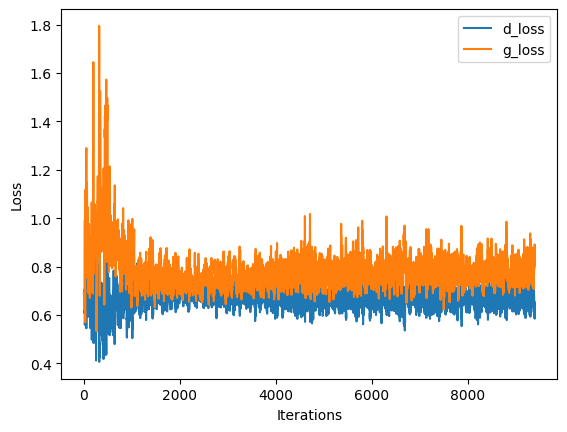

In [ ]:
### Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses), len(d_losses))
gx = np.linspace(0,len(g_losses), len(d_losses))

# Plot the training loss of G and D
plt.plot(dx, d_losses)
plt.plot(gx, g_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 197ms/step


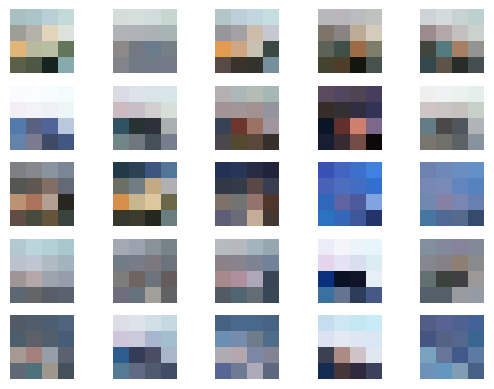

In [ ]:
# load model
model = load_model('/content/cifar_gen_lv1.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X_fake = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X_fake = (X_fake + 1) / 2.0

import numpy as np
X_fake = (X_fake*255).astype(np.uint8)

# plot the result
show_plot(X_fake, 5)

# Lv2 (8x8)

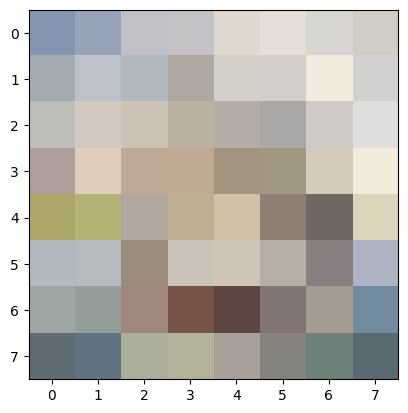

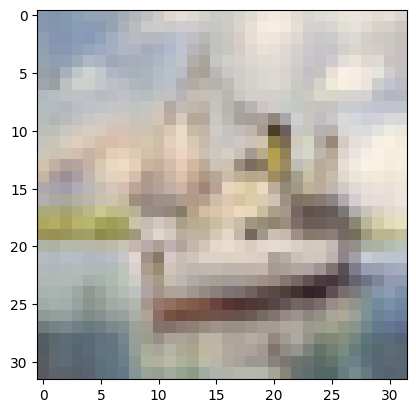

In [ ]:
#Reshape orginal train_set to get real images for 8x8 discriminator
lv2_set = np.array([cv2.resize(img, (8, 8)) for img in train_set])

imgplot = plt.imshow(lv2_set[1])
plt.show()
imgplot = plt.imshow(train_set[1])
plt.show()

In [ ]:
# Check trainable layers
def check_trainable_layers(model):
    for layer in model.layers:
        print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

In [ ]:
#Load 4x4 model
dis_model_lv1 = load_model("/content/cifar_dis_lv1.h5")
dis_model_lv1.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 4, 4, 512)         6656      
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 512)         1049088   
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_19 (Dense)            (None, 1)               

In [ ]:
def define_discriminator_lv2(in_shape=(8,8,3)):
    model = Sequential()

    model.add(Conv2D(512, (2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    #Add convolution layer
    model.add(Conv2D(512, (2,2), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #Load and freeze weights from previous model
    for i in range(2, 4):
      model.add(dis_model_lv1.layers[i])
      model.layers[-1].trainable=False

		# classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

		# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
test_dis = define_discriminator_lv2()
test_dis.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 8, 8, 512)         6656      
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 8, 8, 512)         0         
                                                                 
 conv2d_29 (Conv2D)          (None, 4, 4, 512)         1049088   
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 512)         1049088   
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 flatten_5 (Flatten)         (None, 8192)            

In [ ]:
check_trainable_layers(test_dis)

Layer Name: conv2d_28, Trainable: True
Layer Name: leaky_re_lu_45, Trainable: True
Layer Name: conv2d_29, Trainable: True
Layer Name: leaky_re_lu_46, Trainable: True
Layer Name: conv2d_26, Trainable: False
Layer Name: leaky_re_lu_42, Trainable: False
Layer Name: flatten_5, Trainable: True
Layer Name: dropout_5, Trainable: True
Layer Name: dense_21, Trainable: True


In [ ]:
#Load 4x4 generator
gen_model_lv1 = load_model("/content/cifar_gen_lv1.h5")
gen_model_lv1.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 2048)              206848    
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_15 (Reshape)        (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 4, 4, 128)        1048704   
 Transpose)                                                      
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 4, 4, 128)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 4, 4, 3)           24579     
                                                     

In [ ]:
def define_generator_lv2(latent_dim):
    model = Sequential()

    n_nodes = 512 * 2 * 2
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((2, 2, 512)))

    # load and freeze layers from previous model
    for i in range(3, 5):
      model.add(gen_model_lv1.layers[i])
      model.layers[-1].trainable=False
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
		# generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    return model
test_gen = define_generator_lv2(100)
test_gen.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 2048)              206848    
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_16 (Reshape)        (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 4, 4, 128)        1048704   
 Transpose)                                                      
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 8, 8, 128)        262272    
 Transpose)                                          

In [ ]:
check_trainable_layers(test_gen)

Layer Name: dense_22, Trainable: True
Layer Name: leaky_re_lu_47, Trainable: True
Layer Name: reshape_16, Trainable: True
Layer Name: conv2d_transpose_16, Trainable: False
Layer Name: leaky_re_lu_44, Trainable: False
Layer Name: conv2d_transpose_17, Trainable: True
Layer Name: leaky_re_lu_48, Trainable: True
Layer Name: conv2d_30, Trainable: True


In [ ]:
latent_dim = 100
# create the discriminator
discriminator_lv2 = define_discriminator_lv2()
# create the generator
generator_lv2 = define_generator_lv2(latent_dim)
# create the gan
gan_model_lv2 = define_gan(generator_lv2, discriminator_lv2)
# load image data
dataset = load_real_samples(lv2_set)
# train model
d_losses, g_losses = train(generator_lv2, discriminator_lv2, gan_model_lv2, dataset, latent_dim, 101, "cifar_dis_lv2.h5", "cifar_gen_lv2.h5")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
Epoch>75, Batch 12/93, d_loss=0.586, g_loss=1.057
1/1 [==============================] - 0s 19ms/step
Epoch>75, Batch 13/93, d_loss=0.581, g_loss=0.926
1/1 [==============================] - 0s 20ms/step
Epoch>75, Batch 14/93, d_loss=0.530, g_loss=1.153
1/1 [==============================] - 0s 20ms/step
Epoch>75, Batch 15/93, d_loss=0.547, g_loss=1.052
1/1 [==============================] - 0s 18ms/step
Epoch>75, Batch 16/93, d_loss=0.605, g_loss=0.866
1/1 [==============================] - 0s 20ms/step
Epoch>75, Batch 17/93, d_loss=0.560, g_loss=0.938
1/1 [==============================] - 0s 22ms/step
Epoch>75, Batch 18/93, d_loss=0.568, g_loss=0.971
1/1 [==============================] - 0s 20ms/step
Epoch>75, Batch 19/93, d_loss=0.576, g_loss=1.031
1/1 [==============================] - 0s 17ms/step
Epoch>75, Batch 20/93, d_loss=0.562, g_loss=0.955
1/1 [==========================

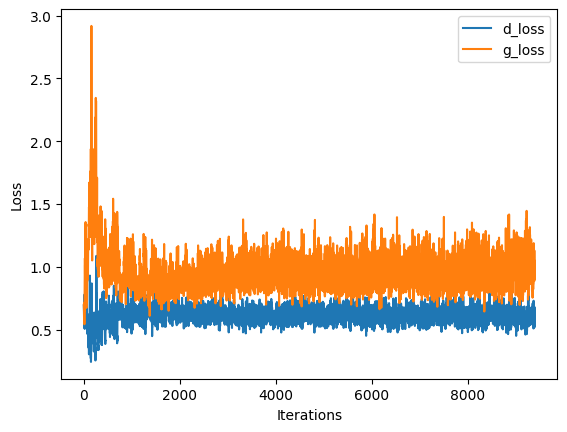

In [ ]:
### Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses), len(d_losses))
gx = np.linspace(0,len(g_losses), len(d_losses))

# Plot the training loss of G and D
plt.plot(dx, d_losses)
plt.plot(gx, g_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 198ms/step


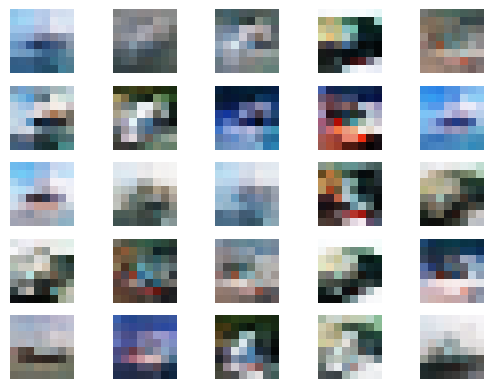

In [ ]:
# load model
model = load_model('/content/cifar_gen_lv2.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X_fake = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X_fake = (X_fake + 1) / 2.0

import numpy as np
X_fake = (X_fake*255).astype(np.uint8)

# plot the result
show_plot(X_fake, 5)

# Lv3 (16x16)

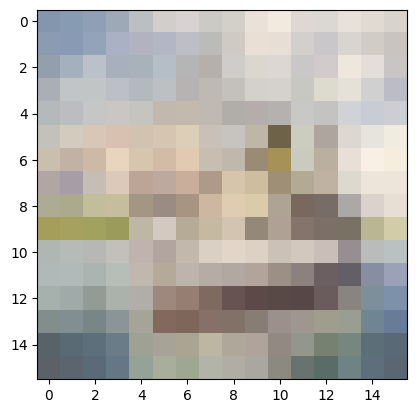

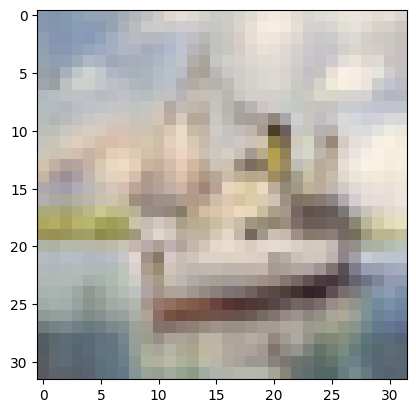

In [ ]:
#Resize train_set to get real images for 16x16 discriminator
lv3_set = np.array([cv2.resize(img, (16, 16)) for img in train_set])

imgplot = plt.imshow(lv3_set[1])
plt.show()
imgplot = plt.imshow(train_set[1])
plt.show()

In [ ]:
#Load previous model
dis_model_lv2 = load_model("/content/cifar_dis_lv2.h5")
dis_model_lv2.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 8, 8, 512)         6656      
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 8, 8, 512)         0         
                                                                 
 conv2d_37 (Conv2D)          (None, 4, 4, 512)         1049088   
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 512)         1049088   
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 flatten_7 (Flatten)         (None, 8192)            

In [ ]:
def define_discriminator_lv3(in_shape=(16,16,3)):
    model = Sequential()

    model.add(Conv2D(512, (2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    #Add new Conv Layer
    model.add(Conv2D(512, (2,2), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

		#Add and freeze layers from previous models
    for i in range(2, 6):
      model.add(dis_model_lv2.layers[i])
      model.layers[-1].trainable=False

		# classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))


		# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
test_dis = define_discriminator_lv3()
test_dis.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 16, 16, 512)       6656      
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 16, 16, 512)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 8, 8, 512)         1049088   
                                                                 
 leaky_re_lu_62 (LeakyReLU)  (None, 8, 8, 512)         0         
                                                                 
 conv2d_37 (Conv2D)          (None, 4, 4, 512)         1049088   
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 512)       

In [ ]:
check_trainable_layers(test_dis)

Layer Name: conv2d_39, Trainable: True
Layer Name: leaky_re_lu_61, Trainable: True
Layer Name: conv2d_40, Trainable: True
Layer Name: leaky_re_lu_62, Trainable: True
Layer Name: conv2d_37, Trainable: False
Layer Name: leaky_re_lu_58, Trainable: False
Layer Name: conv2d_26, Trainable: False
Layer Name: leaky_re_lu_42, Trainable: False
Layer Name: flatten_8, Trainable: True
Layer Name: dropout_8, Trainable: True
Layer Name: dense_29, Trainable: True


In [ ]:
#Load previous model
gen_model_lv2 = load_model("/content/cifar_gen_lv2.h5")
gen_model_lv2.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 2048)              206848    
                                                                 
 leaky_re_lu_59 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_20 (Reshape)        (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 4, 4, 128)        1048704   
 Transpose)                                                      
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 8, 8, 128)        262272    
 Transpose)                                          

In [ ]:
def define_generator_lv3(latent_dim):
    model = Sequential()

    n_nodes = 512 * 2 * 2
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((2, 2, 512)))
		# Load and freeze layers from previous model
    for i in range(3, 7):
      model.add(gen_model_lv2.layers[i])
      model.layers[-1].trainable=False
    #Add new layer
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
		# generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    return model
test_gen = define_generator_lv3(100)
test_gen.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 2048)              206848    
                                                                 
 leaky_re_lu_63 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_21 (Reshape)        (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 4, 4, 128)        1048704   
 Transpose)                                                      
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 8, 8, 128)        262272    
 Transpose)                                          

In [ ]:
check_trainable_layers(test_gen)

Layer Name: dense_30, Trainable: True
Layer Name: leaky_re_lu_63, Trainable: True
Layer Name: reshape_21, Trainable: True
Layer Name: conv2d_transpose_16, Trainable: False
Layer Name: leaky_re_lu_44, Trainable: False
Layer Name: conv2d_transpose_21, Trainable: False
Layer Name: leaky_re_lu_60, Trainable: False
Layer Name: conv2d_transpose_22, Trainable: True
Layer Name: leaky_re_lu_64, Trainable: True
Layer Name: conv2d_41, Trainable: True


In [ ]:
latent_dim = 100
# create the discriminator
discriminator_lv3 = define_discriminator_lv3()
# create the generator
generator_lv3 = define_generator_lv3(latent_dim)
# create the gan
gan_model_lv3 = define_gan(generator_lv3, discriminator_lv3)
# load image data
dataset = load_real_samples(lv3_set)
# train model
d_losses, g_losses = train(generator_lv3, discriminator_lv3, gan_model_lv3, dataset, latent_dim, 101, "cifar_dis_lv3.h5", "cifar_gen_lv3.h5")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
Epoch>75, Batch 12/93, d_loss=0.616, g_loss=1.105
1/1 [==============================] - 0s 25ms/step
Epoch>75, Batch 13/93, d_loss=0.470, g_loss=1.137
1/1 [==============================] - 0s 33ms/step
Epoch>75, Batch 14/93, d_loss=0.517, g_loss=1.299
1/1 [==============================] - 0s 27ms/step
Epoch>75, Batch 15/93, d_loss=0.505, g_loss=0.839
1/1 [==============================] - 0s 17ms/step
Epoch>75, Batch 16/93, d_loss=0.586, g_loss=1.967
1/1 [==============================] - 0s 17ms/step
Epoch>75, Batch 17/93, d_loss=0.542, g_loss=1.845
1/1 [==============================] - 0s 17ms/step
Epoch>75, Batch 18/93, d_loss=0.488, g_loss=0.867
1/1 [==============================] - 0s 19ms/step
Epoch>75, Batch 19/93, d_loss=0.493, g_loss=1.367
1/1 [==============================] - 0s 19ms/step
Epoch>75, Batch 20/93, d_loss=0.470, g_loss=1.362
1/1 [==========================

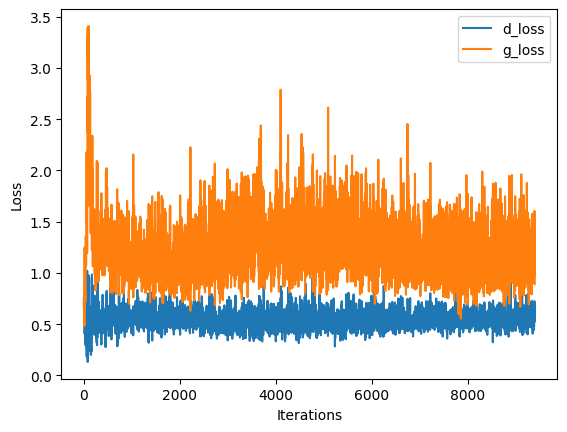

In [ ]:
#Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses), len(d_losses))
gx = np.linspace(0,len(g_losses), len(d_losses))

# Plot the training loss of G and D
plt.plot(dx, d_losses)
plt.plot(gx, g_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 209ms/step


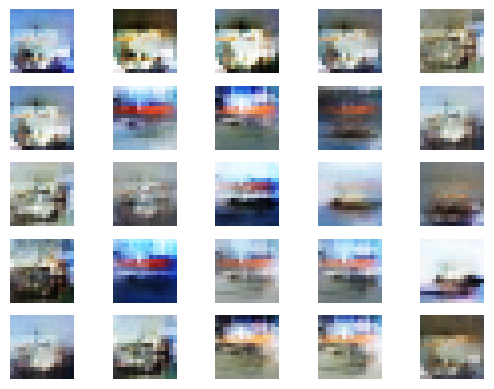

In [ ]:
# load model
model = load_model('/content/cifar_gen_lv3.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X_fake = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X_fake = (X_fake + 1) / 2.0

import numpy as np
X_fake = (X_fake*255).astype(np.uint8)

# plot the result
show_plot(X_fake, 5)

# Lv4 (32x32)

In [ ]:
#Load previous layers
dis_model_lv3 = load_model("/content/cifar_dis_lv3.h5")
dis_model_lv3.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 16, 16, 512)       6656      
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 16, 16, 512)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 8, 8, 512)         1049088   
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 8, 8, 512)         0         
                                                                 
 conv2d_37 (Conv2D)          (None, 4, 4, 512)         1049088   
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 512)       

In [ ]:
def define_discriminator_lv4(in_shape=(32,32,3)):
    model = Sequential()

    model.add(Conv2D(512, (2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    #Add new layer
    model.add(Conv2D(512, (2,2), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #Load and freeze previous layers
    for i in range(2, 8):
      model.add(dis_model_lv3.layers[i])
      model.layers[-1].trainable=False

		# classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))


		# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
test_dis = define_discriminator_lv4()
test_dis.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 32, 32, 512)       6656      
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 32, 32, 512)       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 512)       1049088   
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 16, 16, 512)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 8, 8, 512)         1049088   
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 8, 8, 512)         0         
                                                                 
 conv2d_37 (Conv2D)          (None, 4, 4, 512)       

In [ ]:
check_trainable_layers(test_dis)

Layer Name: conv2d_45, Trainable: True
Layer Name: leaky_re_lu_69, Trainable: True
Layer Name: conv2d_46, Trainable: True
Layer Name: leaky_re_lu_70, Trainable: True
Layer Name: conv2d_43, Trainable: False
Layer Name: leaky_re_lu_66, Trainable: False
Layer Name: conv2d_37, Trainable: False
Layer Name: leaky_re_lu_58, Trainable: False
Layer Name: conv2d_26, Trainable: False
Layer Name: leaky_re_lu_42, Trainable: False
Layer Name: flatten_10, Trainable: True
Layer Name: dropout_10, Trainable: True
Layer Name: dense_33, Trainable: True


In [ ]:
#Load previous model
gen_model_lv3 = load_model("/content/cifar_gen_lv3.h5")
gen_model_lv3.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 2048)              206848    
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_22 (Reshape)        (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 4, 4, 128)        1048704   
 Transpose)                                                      
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 8, 8, 128)        262272    
 Transpose)                                          

In [ ]:
def define_generator_lv4(latent_dim):
    model = Sequential()

    n_nodes = 512 * 2 * 2
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((2, 2, 512)))
		#Load and freeze layers from previous models
    for i in range(3, 9):
      model.add(gen_model_lv3.layers[i])
      model.layers[-1].trainable=False
    #Add new layer
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
		# generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    return model
test_gen = define_generator_lv4(100)
test_gen.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 2048)              206848    
                                                                 
 leaky_re_lu_71 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_23 (Reshape)        (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 4, 4, 128)        1048704   
 Transpose)                                                      
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 8, 8, 128)        262272    
 Transpose)                                          

In [ ]:
check_trainable_layers(test_gen)

Layer Name: dense_34, Trainable: True
Layer Name: leaky_re_lu_71, Trainable: True
Layer Name: reshape_23, Trainable: True
Layer Name: conv2d_transpose_16, Trainable: False
Layer Name: leaky_re_lu_44, Trainable: False
Layer Name: conv2d_transpose_21, Trainable: False
Layer Name: leaky_re_lu_60, Trainable: False
Layer Name: conv2d_transpose_23, Trainable: False
Layer Name: leaky_re_lu_68, Trainable: False
Layer Name: conv2d_transpose_24, Trainable: True
Layer Name: leaky_re_lu_72, Trainable: True
Layer Name: conv2d_47, Trainable: True


In [ ]:
latent_dim = 100
# create the discriminator
discriminator_lv4 = define_discriminator_lv4()
# create the generator
generator_lv4 = define_generator_lv4(latent_dim)
# create the gan
gan_model_lv4 = define_gan(generator_lv4, discriminator_lv4)
# load image data
dataset = load_real_samples(train_set)
# train model
d_losses, g_losses = train(generator_lv4, discriminator_lv4, gan_model_lv4, dataset, latent_dim, 101, "cifar_dis_lv4.h5", "cifar_gen_lv4.h5")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
Epoch>75, Batch 12/93, d_loss=0.462, g_loss=1.326
1/1 [==============================] - 0s 18ms/step
Epoch>75, Batch 13/93, d_loss=0.387, g_loss=2.123
1/1 [==============================] - 0s 18ms/step
Epoch>75, Batch 14/93, d_loss=0.386, g_loss=1.664
1/1 [==============================] - 0s 17ms/step
Epoch>75, Batch 15/93, d_loss=0.542, g_loss=1.589
1/1 [==============================] - 0s 18ms/step
Epoch>75, Batch 16/93, d_loss=0.436, g_loss=1.356
1/1 [==============================] - 0s 17ms/step
Epoch>75, Batch 17/93, d_loss=0.697, g_loss=2.081
1/1 [==============================] - 0s 19ms/step
Epoch>75, Batch 18/93, d_loss=0.624, g_loss=1.529
1/1 [==============================] - 0s 17ms/step
Epoch>75, Batch 19/93, d_loss=0.475, g_loss=1.471
1/1 [==============================] - 0s 19ms/step
Epoch>75, Batch 20/93, d_loss=0.460, g_loss=1.322
1/1 [==========================

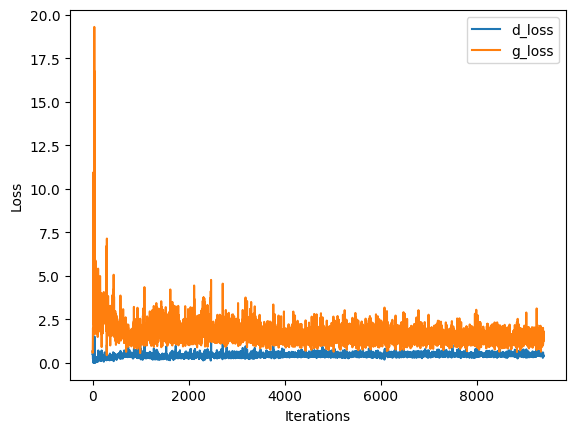

In [ ]:
#Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses), len(d_losses))
gx = np.linspace(0,len(g_losses), len(d_losses))

# Plot the training loss of G and D
plt.plot(dx, d_losses)
plt.plot(gx, g_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 419ms/step


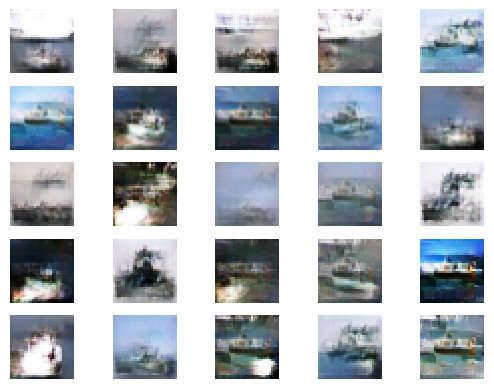

In [ ]:
# load model
model = load_model('/content/cifar_gen_lv4.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X_fake = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X_fake = (X_fake + 1) / 2.0

import numpy as np
X_fake = (X_fake*255).astype(np.uint8)

# plot the result
show_plot(X_fake, 5)